![image.png](https://i.imgur.com/a3uAqnb.png)

# Contents

In this notebook, we will create a RealNVP(real-valued non-volume preserving) generative model for the MNIST dataset, with an intermediate AutoEncoder.

Instead of training the model on direct pixel values and generating images, we will

1. Train an AutoEncoder for the images
2. Convert the data into embeddings using the AutoEncoder
3. Train our RealNVP model on the embeddings
4. Generate embeddings using the RealNVP model and convert them to images using the AutoEncoder's decoder

This notebook is heavily based on [This Repo](https://github.com/SpencerSzabados/realnvp-pytorch/tree/master)

In [1]:
import copy

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn, distributions
from torch.nn import BCELoss
from torchvision import datasets, transforms

We need our layers' transformations to be all invertible and we need their logrism of Jacobian determinant for every transformation. 

So we cannot simple use BatchNorm2d. That is why we redefine another class called LinearBatchNorm below. It does invertible transformations and returns the desired logrism number.

Below are the things LinearBatchNorm does:

![Screenshot 2025-07-08 at 10.42.38.png](<attachment:Screenshot 2025-07-08 at 10.42.38.png>)
![Screenshot 2025-07-08 at 10.51.07.png](<attachment:Screenshot 2025-07-08 at 10.51.07.png>)
![Screenshot 2025-07-08 at 10.51.16.png](<attachment:Screenshot 2025-07-08 at 10.51.16.png>)
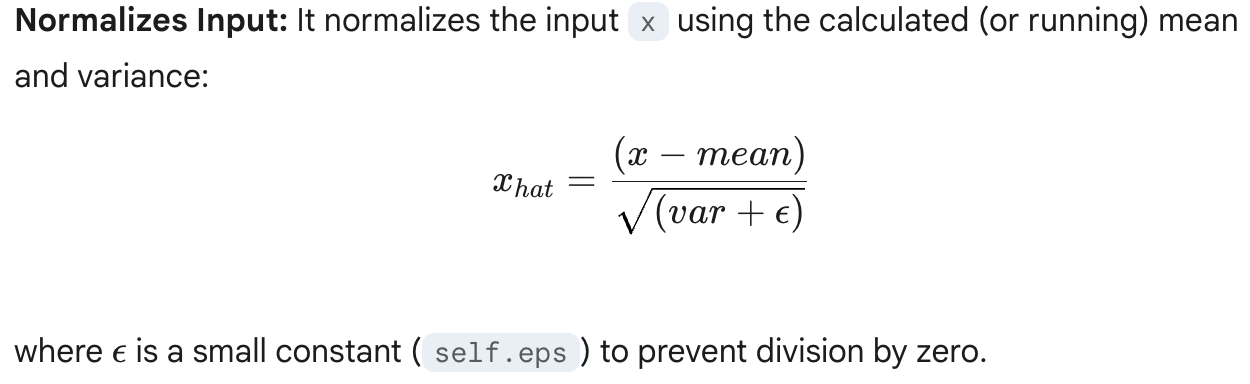
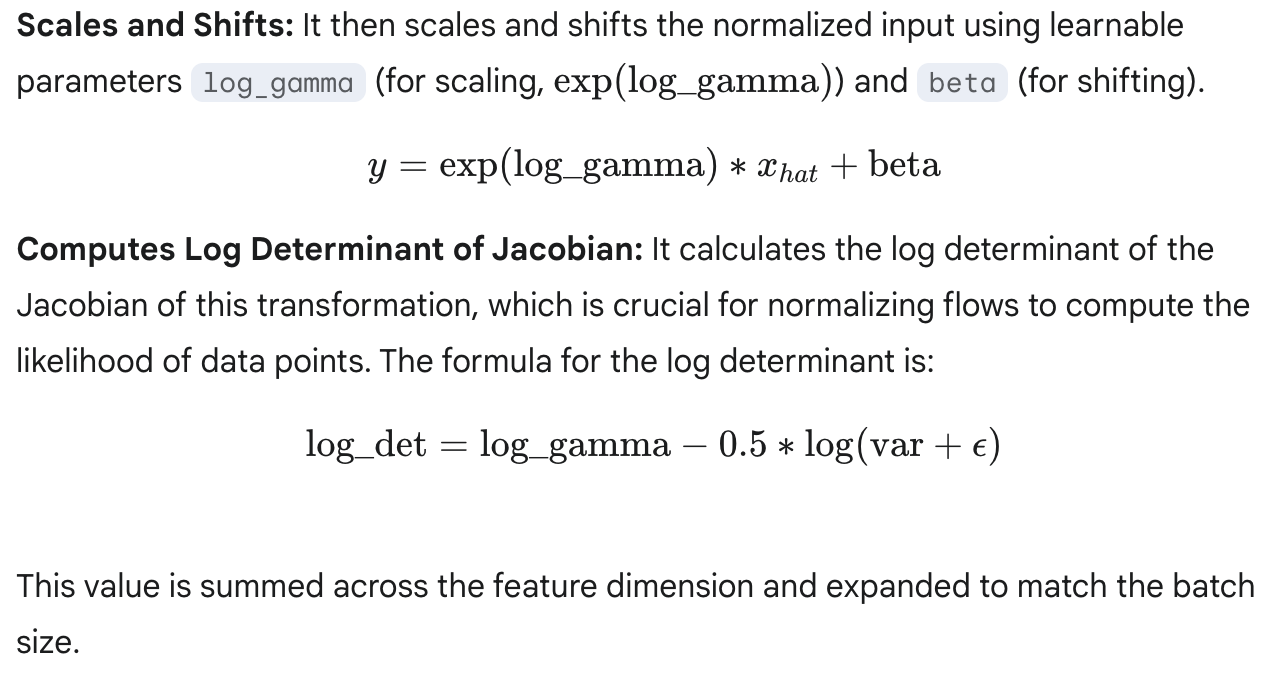
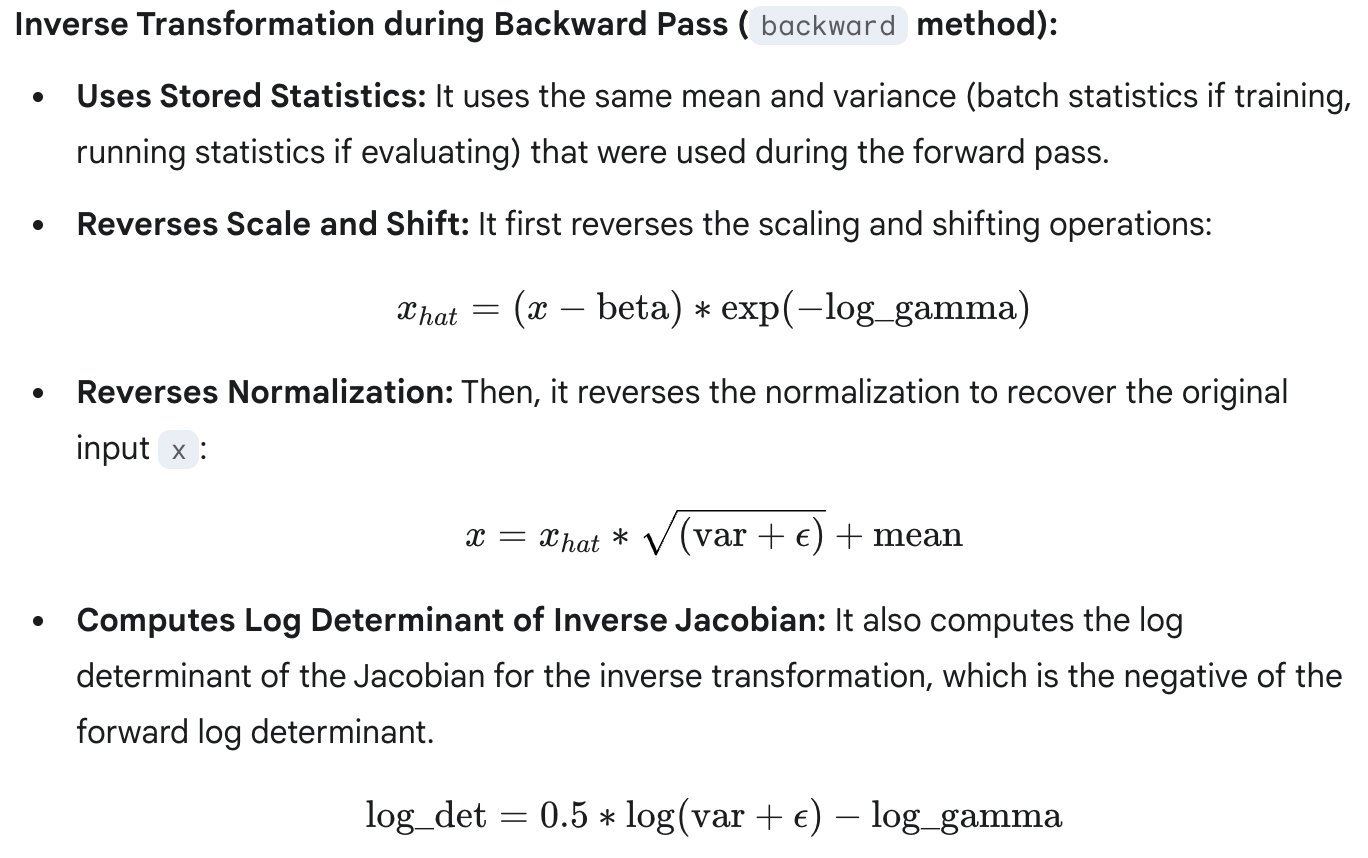

In [2]:
class LinearBatchNorm(nn.Module):
    """
    An (invertible) batch normalization layer.
    This class is mostly inspired from this one:
    https://github.com/kamenbliznashki/normalizing_flows/blob/master/maf.py
    """

    def __init__(self, input_size, momentum=0.9, eps=1e-5):
        super().__init__()
        self.momentum = momentum
        self.eps = eps

        self.log_gamma = nn.Parameter(torch.zeros(input_size))
        self.beta = nn.Parameter(torch.zeros(input_size))

        self.register_buffer('running_mean', torch.zeros(input_size))
        self.register_buffer('running_var', torch.ones(input_size))

    def forward(self, x, **kwargs):
        if self.training:
            self.batch_mean = x.mean(0)
            self.batch_var = x.var(0)

            self.running_mean.mul_(self.momentum).add_(self.batch_mean.data * (1 - self.momentum))
            self.running_var.mul_(self.momentum).add_(self.batch_var.data * (1 - self.momentum))

            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        y = self.log_gamma.exp() * x_hat + self.beta

        log_det = self.log_gamma - 0.5 * torch.log(var + self.eps)

        return y, log_det.expand_as(x).sum(1)

    def backward(self, x, **kwargs):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - self.beta) * torch.exp(-self.log_gamma)
        x = x_hat * torch.sqrt(var + self.eps) + mean

        log_det = 0.5 * torch.log(var + self.eps) - self.log_gamma

        return x, log_det.expand_as(x).sum(1)

![Screenshot 2025-07-08 at 10.52.34.png](<attachment:Screenshot 2025-07-08 at 10.52.34.png>)
![Screenshot 2025-07-08 at 10.54.14.png](<attachment:Screenshot 2025-07-08 at 10.54.14.png>)
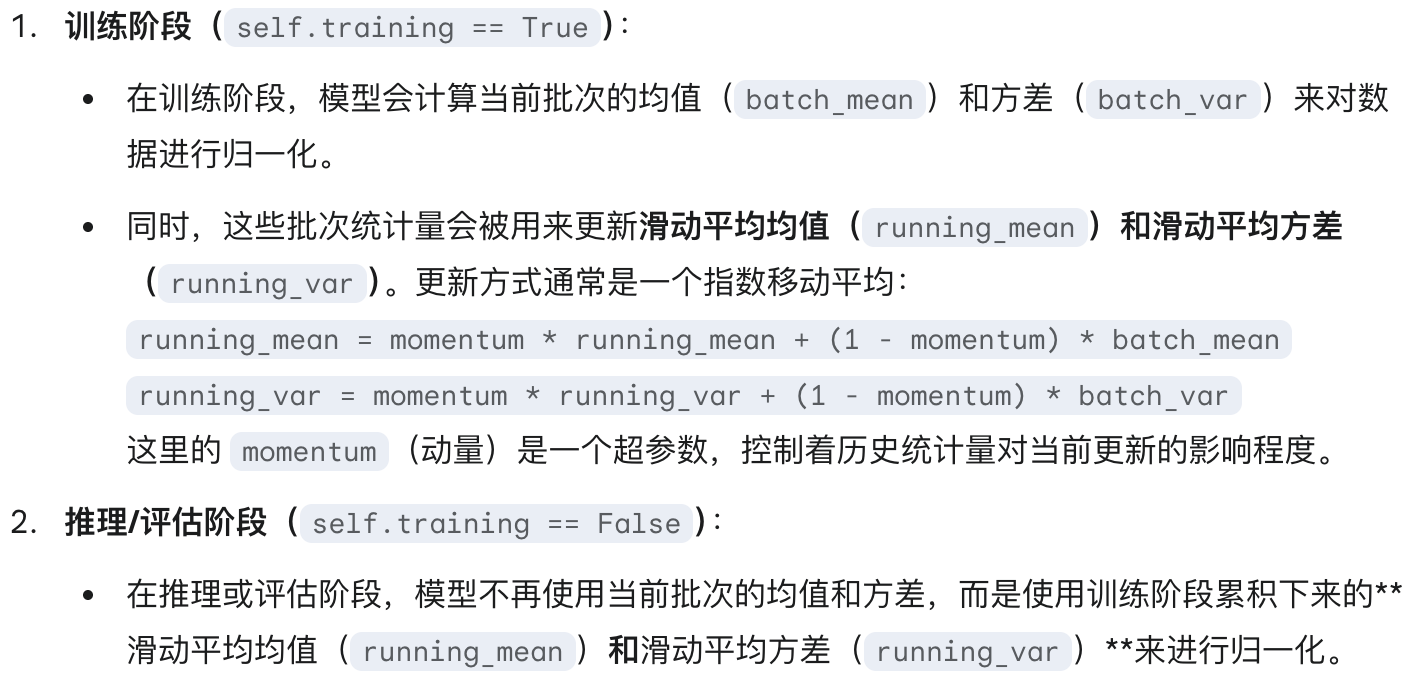
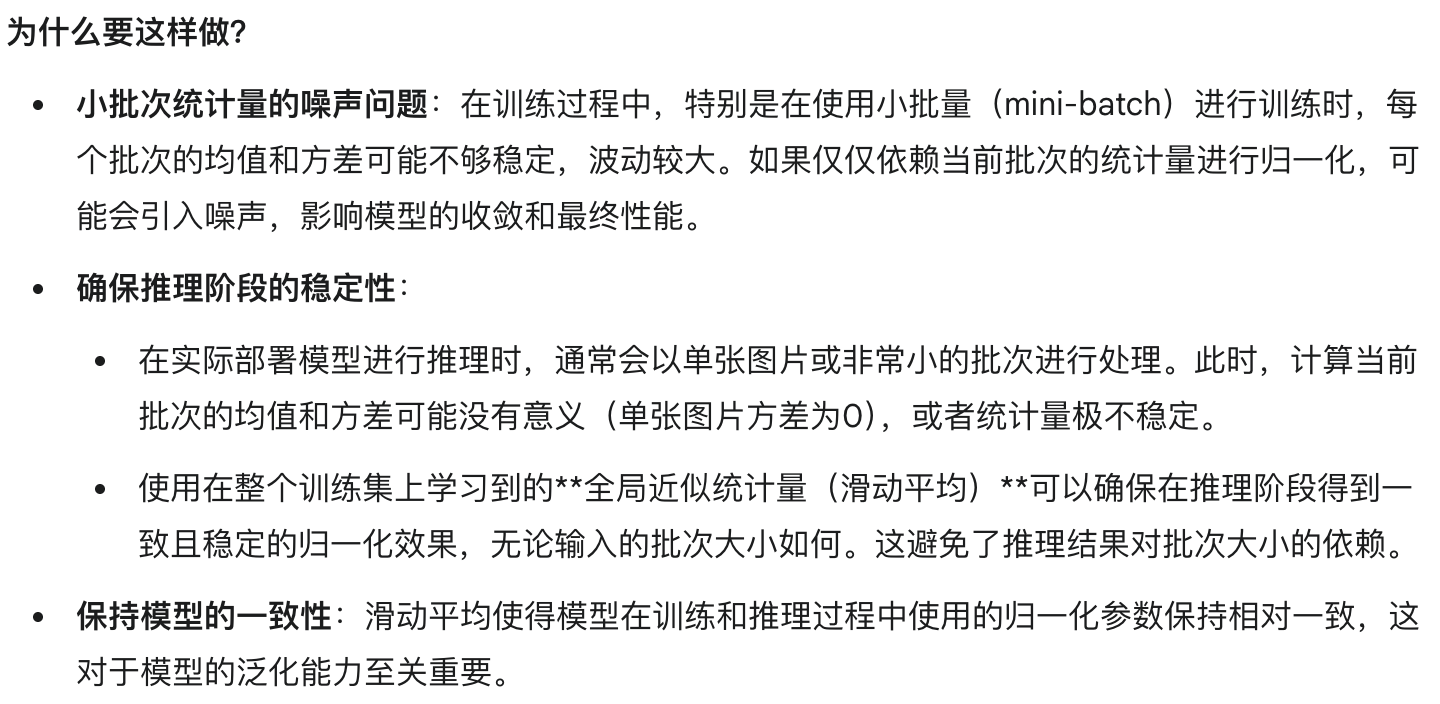

In [ ]:
# 这是 RealNVP 模型的核心。它的思想很巧妙：把输入数据分成两半，用一半（A部分）来计算一个缩放和平移的参数，然后用这个参数去变换另一半（B部分），而A部分保持不变。
# 这样做的最大好处是它的雅可比行列式非常容易计算。
class LinearCouplingLayer(nn.Module):
    """
    Linear coupling layer.
        (i) Split the input x into 2 parts x1 and x2 according to a given mask.
        (ii) Compute s(x2) and t(x2) with given neural network.
        (iii) Final output is [exp(s(x2))*x1 + t(x2); x2].
    The inverse is trivially [(x1 - t(x2))*exp(-s(x2)); x2].
    """

    def __init__(self, input_dim, mask, network_topology, conditioning_size=None, single_function=True):
        super().__init__()

        if conditioning_size is None:
            conditioning_size = 0

        if network_topology is None or len(network_topology) == 0:
            network_topology = [input_dim]

        self.register_buffer('mask', mask)

        self.dim = input_dim

        self.s = [nn.Linear(input_dim + conditioning_size, network_topology[0]), nn.ReLU()]

        for i in range(len(network_topology)):
            t = network_topology[i]
            t_p = network_topology[i - 1]
            self.s.extend([nn.Linear(t_p, t), nn.ReLU()])

        if single_function:
            input_dim = input_dim * 2

        ll = nn.Linear(network_topology[-1], input_dim)

        self.s.append(ll)
        self.s = nn.Sequential(*self.s)

        if single_function:
            self.st = lambda x: (self.s(x).chunk(2, 1))
        else:
            self.t = copy.deepcopy(self.s)
            self.st = lambda x: (self.s(x), self.t(x))

    def forward(self, u, y=None):
        mu = u * self.mask 
        # 使用 mask 将输入 u 分成两部分。mask 是一个由0和1组成的向量，乘以它会保留一部分数据，将另一部分清零。

        if y is not None:
            _mu = torch.cat([y, mu], dim=1)
        else:
            _mu = mu

        s, t = self.st(_mu)
        s = torch.tanh(s)

        x = mu + (1 - self.mask) * (u * s.exp() + t)

        log_abs_det_jacobian = (1 - self.mask) * s
        # 计算对数雅可比行列式，因为变换是线性的，所以计算非常简单，就是 s 的和。

        return x, log_abs_det_jacobian.sum(1)
    
    def backward(self, x, y=None):
        mx = x * self.mask

        if y is not None:
            _mx = torch.cat([y, mx], dim=1)
        else:
            _mx = mx

        s, t = self.st(_mx)
        s = torch.tanh(s)

        u = mx + (1 - self.mask) * (x - t) * torch.exp(-s)

        log_abs_det_jacobian = - (1 - self.mask) * s

        return u, log_abs_det_jacobian.sum(1)

In [ ]:
# 在一个耦合层中，总有一半的数据是不变的。为了让模型能学习到所有维度之间的复杂关系，我们在每两个耦合层之间加一个“置换层”，它会把数据的维度（特征）打乱顺序。
class Permutation(nn.Module):
    """
    A permutation layer.
    """
    def __init__(self, in_ch):
        super().__init__()
        self.in_ch = in_ch
        self.register_buffer('p', torch.randperm(in_ch))
        self.register_buffer('invp', torch.argsort(self.p))

    def forward(self, x, y=None):
        assert x.shape[1] == self.in_ch
        out = x[:, self.p]
        return out, 0

    def backward(self, x, y=None):
        assert x.shape[1] == self.in_ch
        out = x[:, self.invp]
        return out, 0

In [ ]:
# 这是一个“胶水”类，它把我们上面定义的各种“零件”（耦合层、批归一化层、置换层）按照顺序串联起来，形成一个完整的“流”。
class SequentialFlow(nn.Sequential):
    """
    Utility class to build a normalizing flow from a sequence of base transformations.
    During forward and inverse steps, aggregates the sum of the log determinants of the Jacobians.
    """
    def forward(self, x, y=None):
        log_det = 0
        for module in self:
            x, _log_det = module(x, y=y)
            log_det = log_det + _log_det
        return x, log_det

    def backward(self, u, y=None):
        log_det = 0
        for module in reversed(self):
            u, _log_det = module.backward(u, y=y)
            log_det = log_det + _log_det
        return u, log_det

    def forward_steps(self, x, y=None):
        log_det = 0
        xs = [x]
        for module in self:
            x, _log_det = module(x, y=y)
            xs.append(x)
            log_det = log_det + _log_det
        return xs, log_det

    def backward_steps(self, u, y=None):
        log_det = 0
        us = [u]
        for module in reversed(self):
            u, _log_det = module.backward(u, y=y)
            us.append(u)
            log_det = log_det + _log_det
        return us, log_det

In [ ]:
# 现在，我们把所有零件组装成最终的 RealNVP 模型。
class LinearRNVP(nn.Module):
    """
    Main RNVP model, alternating affine coupling layers
    with permutations and/or batch normalization steps.
    """
    def __init__(self, input_dim, coupling_topology, flow_n=2, use_permutation=False,
                 batch_norm=False, mask_type='odds', conditioning_size=None, single_function=False):
        super().__init__()

        self.register_buffer('prior_mean', torch.zeros(input_dim))
        self.register_buffer('prior_var', torch.ones(input_dim))

        if mask_type == 'odds':
            mask = torch.arange(0, input_dim).float() % 2
        elif mask_type == 'half':
            mask = torch.zeros(input_dim)
            mask[:input_dim // 2] = 1
        else:
            assert False

        if coupling_topology is None:
            coupling_topology = [input_dim // 2, input_dim // 2]

        blocks = []

        for i in range(flow_n):

            blocks.append(LinearCouplingLayer(input_dim, mask, network_topology=coupling_topology,
                                              conditioning_size=conditioning_size, single_function=single_function))


            if use_permutation:
                blocks.append(Permutation(input_dim))
            else:
                mask = 1 - mask

            if batch_norm:
                blocks.append(LinearBatchNorm(input_dim))

        self.flows = SequentialFlow(*blocks)

    def logprob(self, x):
        return self.prior.log_prob(x)

    @property
    def prior(self):
        return distributions.Normal(self.prior_mean, self.prior_var)

    def forward(self, x, y=None, return_step=False):
        if return_step:
            return self.flows.forward_steps(x, y)
        return self.flows.forward(x, y)

    def backward(self, u, y=None, return_step=False):
        if return_step:
            return self.flows.backward_steps(u, y)
        return self.flows.backward(u, y)

    def sample(self, samples=1, y=None, return_step=False, return_logdet=False):
        u = self.prior.sample((samples,))
        z, d = self.backward(u, y=y, return_step=return_step)
        if return_logdet:
            d = self.logprob(u).sum(1) + d
            return z, d
        return z

In [7]:
# Set the random seeds
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Loading Data

In [9]:
transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
train_set = datasets.MNIST('./data',
                           train=True,
                           download=True,
                           transform=transform,)

BATCH_SIZE = 100

train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE)

### Autoencoder definition

# **📌 Autoencoder for Dimensionality Reduction**
Before we build the Normalizing Flow, we first need a way to represent the high-dimensional MNIST images (28x28 = 784 pixels) in a much smaller, more manageable space. An **Autoencoder** is perfect for this task.

## **🔹 How it Works**
1️⃣ **Encoder**: A neural network that compresses the input image into a low-dimensional latent vector (embedding). This embedding captures the most important features of the image.

2️⃣ **Decoder**: Another neural network that reconstructs the original image from the latent vector.

By training the Autoencoder to minimize the difference between the original and reconstructed image, the encoder learns to create meaningful, information-rich embeddings. We will then train our Normalizing Flow model on these embeddings instead of the raw pixel data.



## **📌 Expected Input & Output Shapes**
- **Input Image:** `(batch_size, 1, 28, 28)`
- **Latent Embedding:** `(batch_size, 20)`  *(20 is our `EMBEDDING_DIM`)*
- **Reconstructed Image:** `(batch_size, 1, 28, 28)`

In [10]:
EMBEDDING_DIM = 20      # The dimension of the embeddings

In [11]:
class AutoEncoder(nn.Module):
    """
    A simple autoencoder for images. 
    self.linear1 generates the intermediate embeddings that we use for the normalizing flow.
    """
    def __init__(self):
        super().__init__()
        
        # Encoding layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=2, kernel_size=3, bias=False, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, bias=False, padding=1)
        self.linear1 = nn.Linear(in_features=3136, out_features=EMBEDDING_DIM)
        
        # Decoding layers
        self.linear2 = nn.Linear(in_features=EMBEDDING_DIM, out_features=3136)
        self.convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=2, kernel_size=3, padding=1, output_padding=1)


    def forward(self, x):
        
        emb = self.encoder(x)
        _x = self.decoder(emb)
        
        return _x, emb
    
    def decoder(self, emb):

        _x = torch.relu(self.linear2(emb))
        _x = _x.view(-1, 64, 7, 7)
        _x = torch.relu(self.convt1(_x))
        _x = self.convt2(_x)
        
        return _x
    
    def encoder(self, x):
        _x = torch.relu(self.conv1(x))
        _x = torch.relu(self.conv2(_x))
        sh = _x.shape

        _x = torch.relu(torch.flatten(_x, 1))
        
        emb = self.linear1(_x)
        
        return emb

### Autoencoder training on MNIST

In [12]:
# Build the autoencoder
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

criterion = BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

AE_EPOCHS = 10  # Epochs for training the autoencoder

In [13]:
for j in range(AE_EPOCHS):

    losses = []
    for batch_idx, data in enumerate(tqdm(train_loader)):

        x, _ = data
        x = x.to(device)

        # Run the autoencoder
        _x, emb = autoencoder(x)
        _x = torch.sigmoid(_x)

        # Compute Reconstruction loss
        rec_loss = criterion(_x, x)

        losses.append(rec_loss.item())

        autoencoder.zero_grad()
        rec_loss.backward()
        optimizer.step()
    
    
    print(f'Epoch #{j+1}, Loss: {sum(losses)/len(losses):.4f}')

100%|██████████| 600/600 [00:12<00:00, 48.04it/s]


Epoch #1, Loss: 0.1596


100%|██████████| 600/600 [00:22<00:00, 27.11it/s]


Epoch #2, Loss: 0.0982


100%|██████████| 600/600 [00:24<00:00, 24.45it/s]


Epoch #3, Loss: 0.0919


100%|██████████| 600/600 [00:28<00:00, 20.95it/s]


Epoch #4, Loss: 0.0889


100%|██████████| 600/600 [00:30<00:00, 19.56it/s]


Epoch #5, Loss: 0.0870


100%|██████████| 600/600 [00:25<00:00, 23.21it/s]


Epoch #6, Loss: 0.0856


100%|██████████| 600/600 [00:24<00:00, 24.04it/s]


Epoch #7, Loss: 0.0847


100%|██████████| 600/600 [00:24<00:00, 24.36it/s]


Epoch #8, Loss: 0.0839


100%|██████████| 600/600 [00:24<00:00, 24.32it/s]


Epoch #9, Loss: 0.0833


100%|██████████| 600/600 [00:25<00:00, 23.35it/s]

Epoch #10, Loss: 0.0828


### Creating a new dataset containing the embeddings and the associated labels

We replace the original x with the corresponding embedding from the trained autoencoder

In [14]:
embedded_data = []

for batch_idx, data in enumerate(tqdm(train_loader)):

    with torch.no_grad():
        x, y = data

        x = x.to(device)

        _, emb = autoencoder(x)

        for j in range(len(emb)):
            embedded_data.append((emb[j], y[j]))

100%|██████████| 600/600 [00:07<00:00, 75.64it/s]


In [15]:
embedded_train_loader = torch.utils.data.DataLoader(embedded_data, BATCH_SIZE)

### Normalizing Flow training

# **📌 RealNVP Normalizing Flow Model**
A **Normalizing Flow** is a type of generative model that learns an explicit, invertible transformation between a complex data distribution (like our image embeddings) and a simple base distribution (like a standard normal distribution). The model we use here is **RealNVP (Real-valued Non-Volume Preserving)**.

## **🔹 Key Concepts**
1️⃣ **Invertible Transformation**: The core idea is a function `f` that can map a data point `x` to a latent point `z` (`z = f(x)`), and can also be perfectly inverted to map `z` back to `x` (`x = f⁻¹(z)`). This allows for both density estimation and generation.

2️⃣ **Change of Variables Formula**: Normalizing Flows use this formula to calculate the exact likelihood of a data point. The loss function aims to maximize this likelihood. The key is that the transformation's Jacobian determinant must be easy to compute.

3️⃣ **Coupling Layers**: RealNVP achieves an easily computable Jacobian by using special "coupling layers." These layers split the input vector into two parts, transforming one part based on the other, which is left unchanged. By stacking and alternating these layers, the model can learn highly complex transformations.



## **📌 Expected Input & Output Shapes**
- **Input (Embeddings):** `(batch_size, 20)`
- **Conditional Input (Labels):** `(batch_size, 10)`
- **Output (Latent `u`):** `(batch_size, 20)`

In [16]:
FLOW_N = 9              # Number of affine coupling layers
RNVP_TOPOLOGY = [200]   # Size of the hidden layers in each coupling layer

In [17]:
# See the file realmvp.py for the full definition
nf_model = LinearRNVP(input_dim=EMBEDDING_DIM, coupling_topology=RNVP_TOPOLOGY,
                      flow_n=FLOW_N, batch_norm=True,
                      mask_type='odds', conditioning_size=10,
                      use_permutation=True, single_function=True).to(device)

nf_optimizer = torch.optim.Adam(nf_model.parameters(), lr=1e-4, weight_decay=1e-5)

In [18]:
NF_EPOCHS = 20          # Epochs for training the normalizing flow

In [19]:
for j in range(NF_EPOCHS):

    nf_model.train()

    losses = []
    for batch_idx, data in enumerate(tqdm(embedded_train_loader)):

        emb, y = data
        emb = emb.to(device)
        y = y.to(device)

        y = nn.functional.one_hot(y, 10).to(device).float()
        
        # Get the inverse transformation and the corresponding log determinant of the Jacobian
        u, log_det = nf_model.forward(emb, y=y) 

        # Train via maximum likelihood
        prior_logprob = nf_model.logprob(u)
        log_prob = -torch.mean(prior_logprob.sum(1) + log_det)

        losses.append(log_prob.item())

        nf_model.zero_grad()
        log_prob.backward()
        nf_optimizer.step()
    
    print(f'Epoch #{j+1}, Loss: {sum(losses)/len(losses):.4f}')

100%|██████████| 600/600 [00:05<00:00, 112.81it/s]


Epoch #1, Loss: 49.4416


100%|██████████| 600/600 [00:05<00:00, 114.07it/s]


Epoch #2, Loss: 44.8435


100%|██████████| 600/600 [00:05<00:00, 117.01it/s]


Epoch #3, Loss: 43.6443


100%|██████████| 600/600 [00:05<00:00, 115.45it/s]


Epoch #4, Loss: 43.0088


100%|██████████| 600/600 [00:05<00:00, 114.60it/s]


Epoch #5, Loss: 42.5799


100%|██████████| 600/600 [00:05<00:00, 116.87it/s]


Epoch #6, Loss: 42.2563


100%|██████████| 600/600 [00:05<00:00, 116.48it/s]


Epoch #7, Loss: 41.9945


100%|██████████| 600/600 [00:05<00:00, 113.98it/s]


Epoch #8, Loss: 41.7721


100%|██████████| 600/600 [00:05<00:00, 114.00it/s]


Epoch #9, Loss: 41.5787


100%|██████████| 600/600 [00:05<00:00, 117.06it/s]


Epoch #10, Loss: 41.4067


100%|██████████| 600/600 [00:05<00:00, 115.39it/s]


Epoch #11, Loss: 41.2520


100%|██████████| 600/600 [00:05<00:00, 115.81it/s]


Epoch #12, Loss: 41.1108


100%|██████████| 600/600 [00:05<00:00, 115.94it/s]


Epoch #13, Loss: 40.9812


100%|██████████| 600/600 [00:05<00:00, 114.45it/s]


Epoch #14, Loss: 40.8608


100%|██████████| 600/600 [00:05<00:00, 117.85it/s]


Epoch #15, Loss: 40.7498


100%|██████████| 600/600 [00:05<00:00, 116.06it/s]


Epoch #16, Loss: 40.6462


100%|██████████| 600/600 [00:05<00:00, 115.99it/s]


Epoch #17, Loss: 40.5493


100%|██████████| 600/600 [00:05<00:00, 118.55it/s]


Epoch #18, Loss: 40.4588


100%|██████████| 600/600 [00:05<00:00, 115.51it/s]


Epoch #19, Loss: 40.3731


100%|██████████| 600/600 [00:05<00:00, 116.02it/s]

Epoch #20, Loss: 40.2918


### Evaluating the Model

We will train the Normalizing Flow model to learn the distribution of the embeddings created by our Autoencoder.

1️⃣ **Forward Pass** → Transform an image embedding `emb` into a latent vector `u` from the prior distribution.

2️⃣ **Compute Loss** → Maximize the log-likelihood using the `log_det` from the transformation and the `logprob` of `u` under the prior.

3️⃣ **Backward Pass** → Update model parameters to improve the transformation.

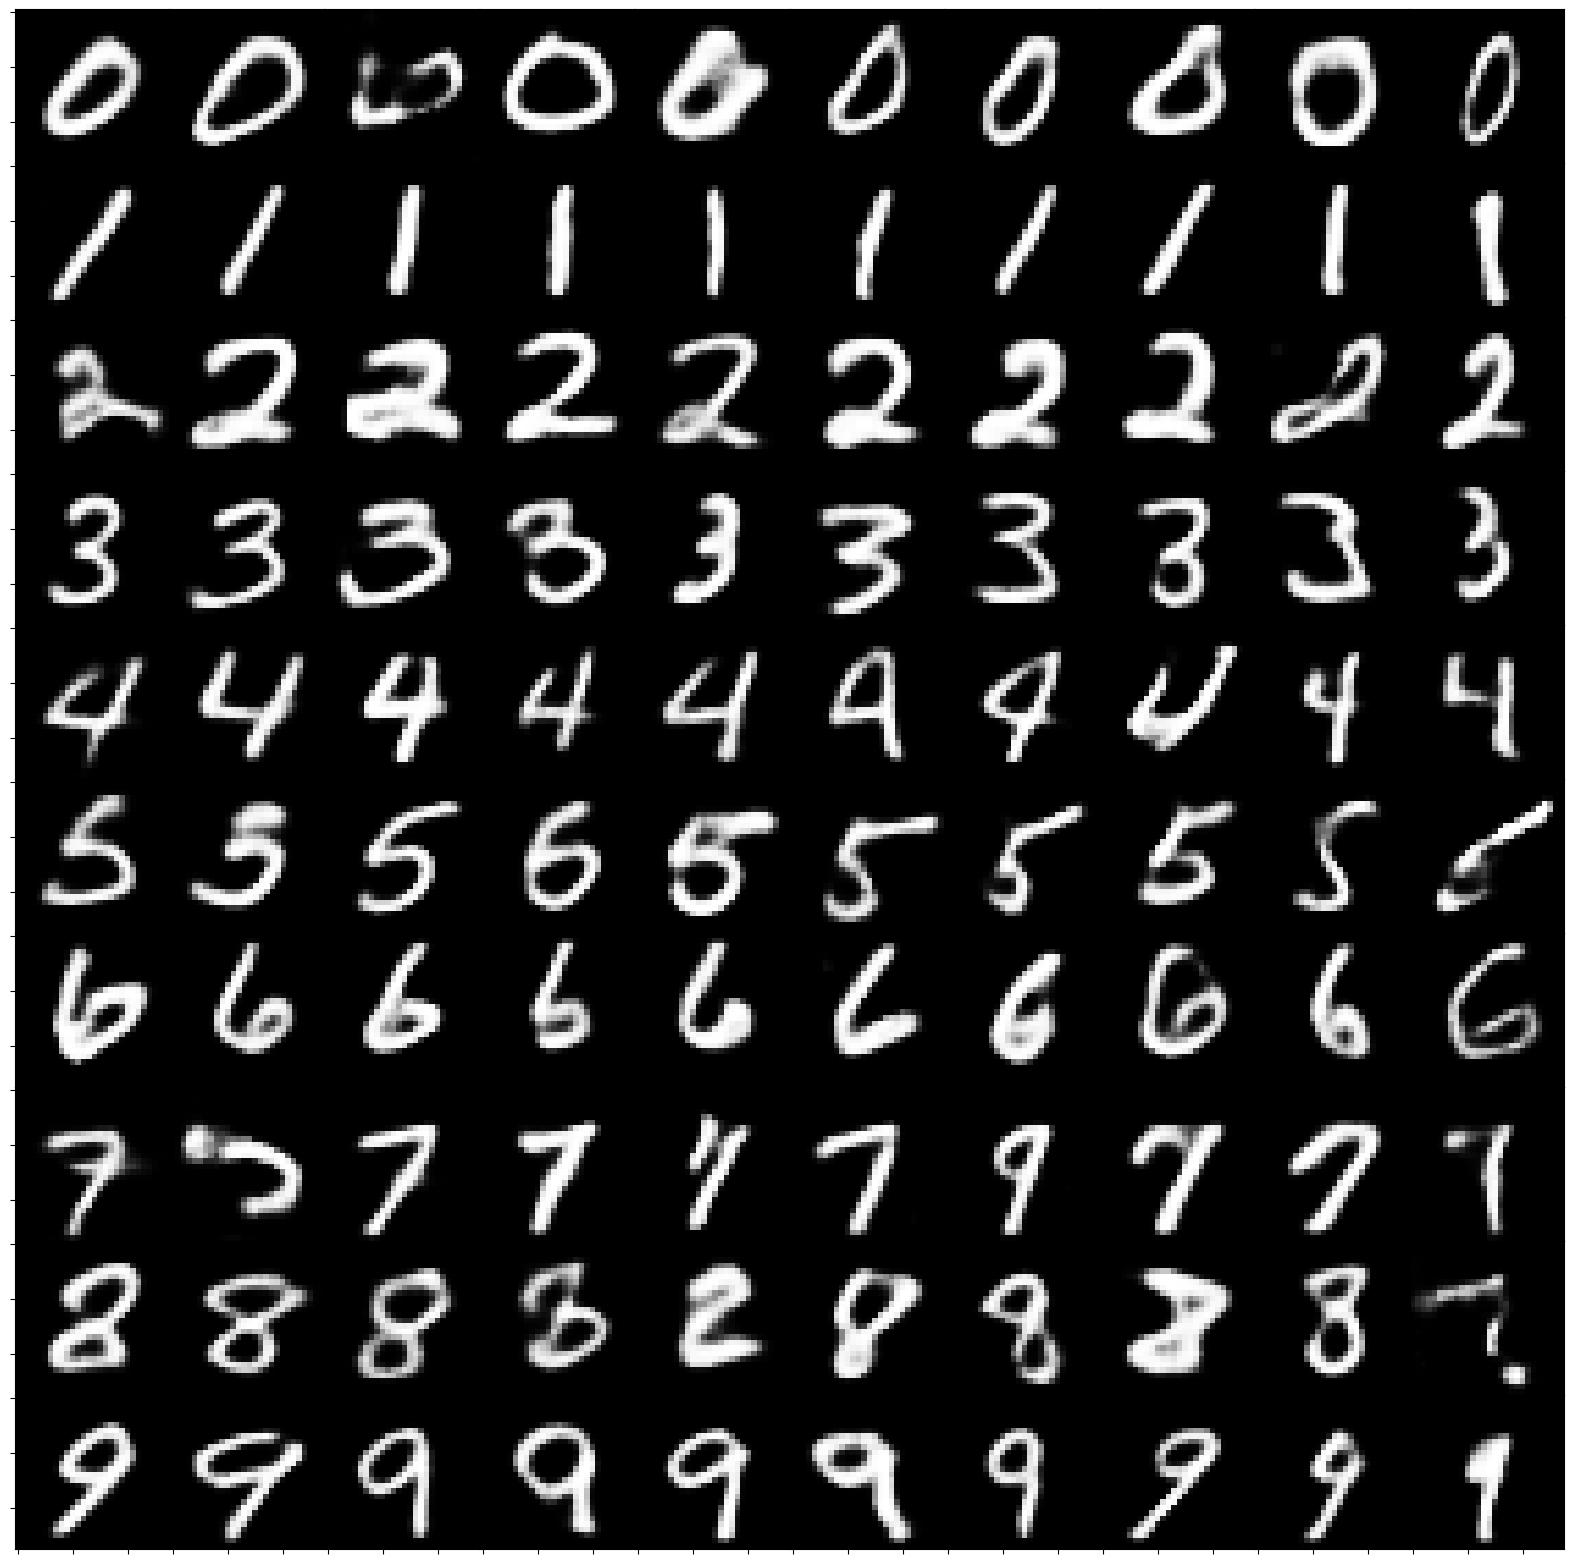

In [20]:
sample_n = 10
f, axs = plt.subplots(nrows=10, ncols=sample_n, figsize=(20, 20))

for ax in axs:
    for a in ax:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0)

nf_model.eval()
with torch.no_grad():

    for i in range(10):

        y = torch.nn.functional.one_hot(torch.tensor([i]*sample_n), 10).to(device).float()
        emb, d = nf_model.sample(sample_n, y=y, return_logdet=True)  # generating the embeddings

        # convert embedding to image using autoencoder's decoder
        z = autoencoder.decoder(emb)

        d_sorted = d.sort(0)[1].flip(0)
        z = z[d_sorted]
        z = torch.sigmoid(z).cpu()

        for j in range(sample_n):
            axs[i][j].imshow(z[j].reshape(28, 28), cmap='gray')

plt.show()

## **🔹 Exercise: Experiment with Hyperparameters**

The quality of the generated images depends on both the Autoencoder's representation and the Normalizing Flow's ability to model it. Try experimenting to see how the results change!

### **📝 Tasks**

1.  **Embedding Dimension**: In the Autoencoder, change `EMBEDDING_DIM`. How does a smaller dimension (e.g., `10`) or a larger one (e.g., `50`) affect the final generated images?
2.  **Flow Depth**: Modify `FLOW_N`, the number of coupling layers in the `LinearRNVP` model. Does a deeper flow (e.g., `12`) produce sharper or more diverse samples? What about a shallower one (e.g., `4`)?
3.  **Network Topology**: Adjust `RNVP_TOPOLOGY`, which controls the size of the hidden networks inside each coupling layer. Try `[100]` or `[400, 400]`. How does the complexity of these networks impact performance and training time?
4.  **Batch Normalization**: Turn off `batch_norm` in the `LinearRNVP` constructor. How does this affect training stability and the final results?


### Contributed by: Ali Habibullah.